# CNN-LSTM Pipeline: Data Analytics & Autocorrelation Analysis

This notebook performs comprehensive data analytics to determine optimal window sizes for time-series modeling based on autocorrelation analysis.

## 1. Import Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [60]:
# Load training data
train_data = pd.read_csv('../data/pirate_pain_train.csv')
train_labels = pd.read_csv('../data/pirate_pain_train_labels.csv')

# Merge data with labels
data = train_data.merge(train_labels, on='sample_index')

print(f"Dataset shape: {data.shape}")
print(f"Number of samples: {data['sample_index'].nunique()}")
print(f"Number of timesteps per sample: {data.groupby('sample_index').size().iloc[0]}")
print(f"\nColumns: {data.columns.tolist()}")
print(f"\nPain level distribution:")
print(data.groupby('sample_index')['label'].first().value_counts())

data.head()

Dataset shape: (105760, 41)
Number of samples: 661
Number of timesteps per sample: 160

Columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30', 'label']

Pain level distribution:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [61]:
# Remove joint_30 because it holds no information
data = data.drop(columns=["joint_30"])

## 3. Autocorrelation Analysis

Autocorrelation Function (ACF) measures the correlation between a time series and its lagged values. This helps us determine:
- **Optimal window size**: How far back in time do current values depend on past values?
- **Memory of the system**: How long does the effect of a motion persist?
- **Appropriate lag for modeling**: What temporal dependencies should our model capture?

In [62]:
# Select a few representative samples from each pain level
samples_per_class = 3
sample_ids = []

for label in data['label'].unique():
    label_samples = data[data['label'] == label]['sample_index'].unique()
    selected = np.random.choice(label_samples, min(samples_per_class, len(label_samples)), replace=False)
    sample_ids.extend(selected)

print(f"Selected {len(sample_ids)} samples for analysis")
print(f"Sample IDs: {sample_ids}")

Selected 9 samples for analysis
Sample IDs: [np.int64(162), np.int64(114), np.int64(564), np.int64(2), np.int64(236), np.int64(546), np.int64(164), np.int64(105), np.int64(332)]


In [63]:
# Get joint columns (excluding identifiers and labels)
joint_cols = [col for col in data.columns if col.startswith('joint_')]

print(f"Number of joint features: {len(joint_cols)}")
print(f"Joint columns: {joint_cols}... (showing first 5)")

Number of joint features: 30
Joint columns: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']... (showing first 5)


### 3.1 Compute Average Autocorrelation Across All Features

In [64]:
# Compute autocorrelation for each feature in selected samples
max_lag = 80  # Analyze up to half the sequence length (160/2)

acf_results = {}

for sample_id in sample_ids:
    sample_data = data[data['sample_index'] == sample_id]
    label = sample_data['label'].iloc[0]
    
    for joint_col in joint_cols:
        series = sample_data[joint_col].values
        
        # Compute ACF
        acf_values = acf(series, nlags=max_lag, fft=True)
        
        # Store results
        key = (sample_id, joint_col, label)
        acf_results[key] = acf_values

print(f"Computed ACF for {len(acf_results)} feature-sample combinations")
print(f"ACF computed up to lag {max_lag}")

Computed ACF for 270 feature-sample combinations
ACF computed up to lag 80


In [65]:
# Calculate average ACF across all features and samples
acf_matrix = np.array(list(acf_results.values()))
avg_acf = np.mean(acf_matrix, axis=0)
std_acf = np.std(acf_matrix, axis=0)
print(acf_matrix)

# Calculate average ACF by label
avg_acf_by_label = {}
for label in data['label'].unique():
    label_acfs = [acf for key, acf in acf_results.items() if key[2] == label]
    avg_acf_by_label[label] = np.mean(label_acfs, axis=0)

print("ACF statistics computed successfully!")

[[ 1.         -0.01646091  0.12399642 ...  0.11423752  0.00182864
  -0.02643545]
 [ 1.          0.06077453  0.10260825 ... -0.06419047 -0.04889834
  -0.11056757]
 [ 1.         -0.04535861  0.21560904 ...  0.07457164 -0.04360045
  -0.03304158]
 ...
 [ 1.          0.41816059  0.36243029 ... -0.1842675  -0.21912805
  -0.19731296]
 [ 1.          0.31250312  0.37288422 ...  0.01927104 -0.058347
  -0.05926556]
 [ 1.          0.35188767  0.20608253 ...  0.02243328 -0.03850333
  -0.07334066]]
ACF statistics computed successfully!


### 3.2 Visualize Autocorrelation Functions

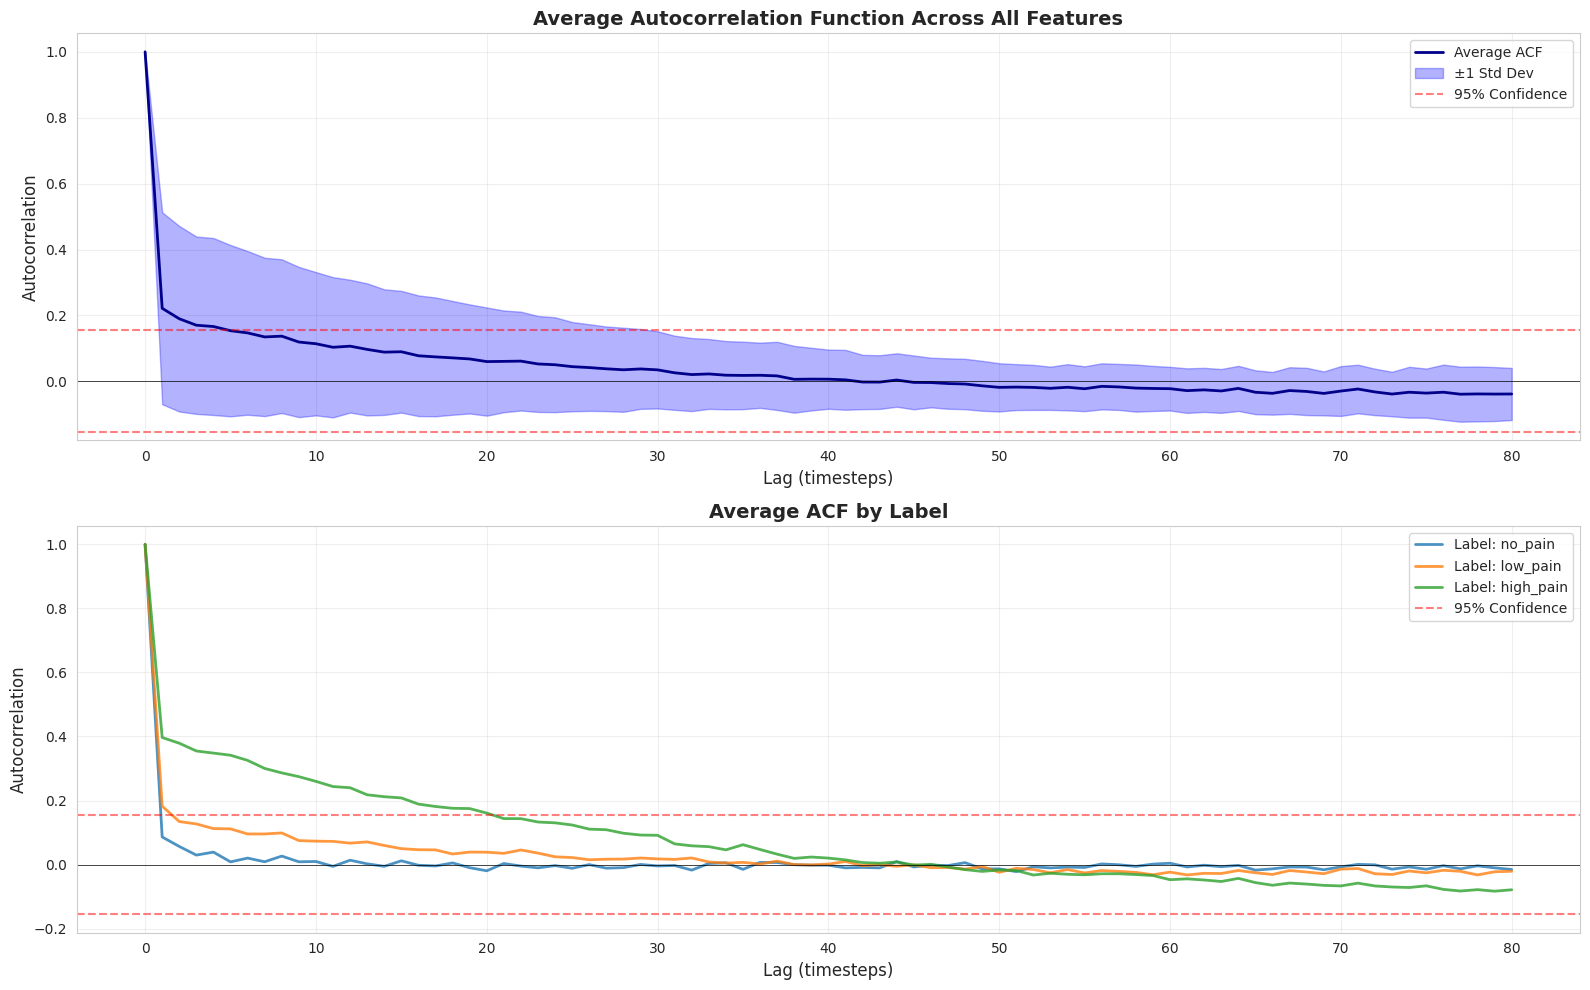

In [66]:
# Plot 1: Average ACF with confidence bands
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot average ACF across all features
lags = np.arange(max_lag + 1)
axes[0].plot(lags, avg_acf, linewidth=2, color='darkblue', label='Average ACF')
axes[0].fill_between(lags, avg_acf - std_acf, avg_acf + std_acf, 
                       alpha=0.3, color='blue', label='±1 Std Dev')

# Add confidence interval lines (95% confidence)
confidence_interval = 1.96 / np.sqrt(160)  # 160 timesteps per sample
axes[0].axhline(y=confidence_interval, linestyle='--', color='red', alpha=0.5, label='95% Confidence')
axes[0].axhline(y=-confidence_interval, linestyle='--', color='red', alpha=0.5)
axes[0].axhline(y=0, linestyle='-', color='black', linewidth=0.5)

axes[0].set_xlabel('Lag (timesteps)', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)
axes[0].set_title('Average Autocorrelation Function Across All Features', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot ACF by label
for label, acf_values in avg_acf_by_label.items():
    axes[1].plot(lags, acf_values, linewidth=2, label=f'Label: {label}', alpha=0.8)

axes[1].axhline(y=confidence_interval, linestyle='--', color='red', alpha=0.5, label='95% Confidence')
axes[1].axhline(y=-confidence_interval, linestyle='--', color='red', alpha=0.5)
axes[1].axhline(y=0, linestyle='-', color='black', linewidth=0.5)

axes[1].set_xlabel('Lag (timesteps)', fontsize=12)
axes[1].set_ylabel('Autocorrelation', fontsize=12)
axes[1].set_title('Average ACF by Label', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Determine Optimal Window Sizes

We'll analyze:
1. **Lag where ACF drops below confidence interval** → minimum meaningful window
2. **Lag where ACF becomes negligible (< 0.1)** → practical window size
3. **Effective memory length** → how long past influences present

In [67]:
# Calculate key statistics
confidence_interval = 1.96 / np.sqrt(160)

# Find where ACF first drops below confidence interval
below_confidence = np.where(np.abs(avg_acf[1:]) < confidence_interval)[0]
if len(below_confidence) > 0:
    first_insignificant_lag = below_confidence[0] + 1
else:
    first_insignificant_lag = max_lag

# Find where ACF drops below 0.1 (negligible correlation)
below_threshold = np.where(np.abs(avg_acf[1:]) < 0.1)[0]
if len(below_threshold) > 0:
    negligible_lag = below_threshold[0] + 1
else:
    negligible_lag = max_lag

# Calculate effective memory (cumulative sum approach)
# Memory length where 90% of cumulative correlation is reached
cumsum_acf = np.cumsum(np.abs(avg_acf))
total_correlation = cumsum_acf[-1]
memory_90 = np.where(cumsum_acf >= 0.9 * total_correlation)[0]
if len(memory_90) > 0:
    effective_memory = memory_90[0]
else:
    effective_memory = max_lag

print("=" * 70)
print("AUTOCORRELATION ANALYSIS RESULTS")
print("=" * 70)
print(f"\n1. First Insignificant Lag (below 95% confidence): {first_insignificant_lag} timesteps")
print(f"   → Minimum window size: {first_insignificant_lag}")
print(f"\n2. Negligible Correlation Lag (ACF < 0.1): {negligible_lag} timesteps")
print(f"   → Practical window size: {negligible_lag}")
print(f"\n3. Effective Memory (90% cumulative correlation): {effective_memory} timesteps")
print(f"   → Maximum useful window: {effective_memory}")
print(f"\n4. ACF at key lags:")
for lag in [5, 10, 15, 20, 30, 40, 50]:
    if lag <= max_lag:
        print(f"   Lag {lag:2d}: ACF = {avg_acf[lag]:.4f}")

print("\n" + "=" * 70)
print("RECOMMENDED WINDOW SIZES FOR MODELING:")
print("=" * 70)
print(f"• Short-term patterns:  5-15 timesteps (kernel size for Conv layers)")
print(f"• Medium-term context:  {negligible_lag}-{effective_memory} timesteps (sequence length)")
print(f"• Full sequence:        160 timesteps (current data length)")
print("=" * 70)

AUTOCORRELATION ANALYSIS RESULTS

1. First Insignificant Lag (below 95% confidence): 5 timesteps
   → Minimum window size: 5

2. Negligible Correlation Lag (ACF < 0.1): 13 timesteps
   → Practical window size: 13

3. Effective Memory (90% cumulative correlation): 66 timesteps
   → Maximum useful window: 66

4. ACF at key lags:
   Lag  5: ACF = 0.1538
   Lag 10: ACF = 0.1143
   Lag 15: ACF = 0.0899
   Lag 20: ACF = 0.0601
   Lag 30: ACF = 0.0350
   Lag 40: ACF = 0.0067
   Lag 50: ACF = -0.0181

RECOMMENDED WINDOW SIZES FOR MODELING:
• Short-term patterns:  5-15 timesteps (kernel size for Conv layers)
• Medium-term context:  13-66 timesteps (sequence length)
• Full sequence:        160 timesteps (current data length)


### 3.4 Partial Autocorrelation Function (PACF)

PACF helps identify the direct effect of past values, removing indirect correlations. This is particularly useful for determining optimal LSTM/GRU hidden state sizes and sequence dependencies.

In [68]:
# Compute PACF for selected samples
pacf_results = {}

for sample_id in sample_ids:
    sample_data = data[data['sample_index'] == sample_id]
    label = sample_data['label'].iloc[0]
    
    for joint_col in joint_cols:
        series = sample_data[joint_col].values
        
        # Compute PACF
        pacf_values = pacf(series, nlags=max_lag, method='ywm')
        
        # Store results
        key = (sample_id, joint_col, label)
        pacf_results[key] = pacf_values

# Calculate average PACF
pacf_matrix = np.array(list(pacf_results.values()))
avg_pacf = np.mean(pacf_matrix, axis=0)
std_pacf = np.std(pacf_matrix, axis=0)

print(f"PACF computed for {len(pacf_results)} feature-sample combinations")

PACF computed for 270 feature-sample combinations


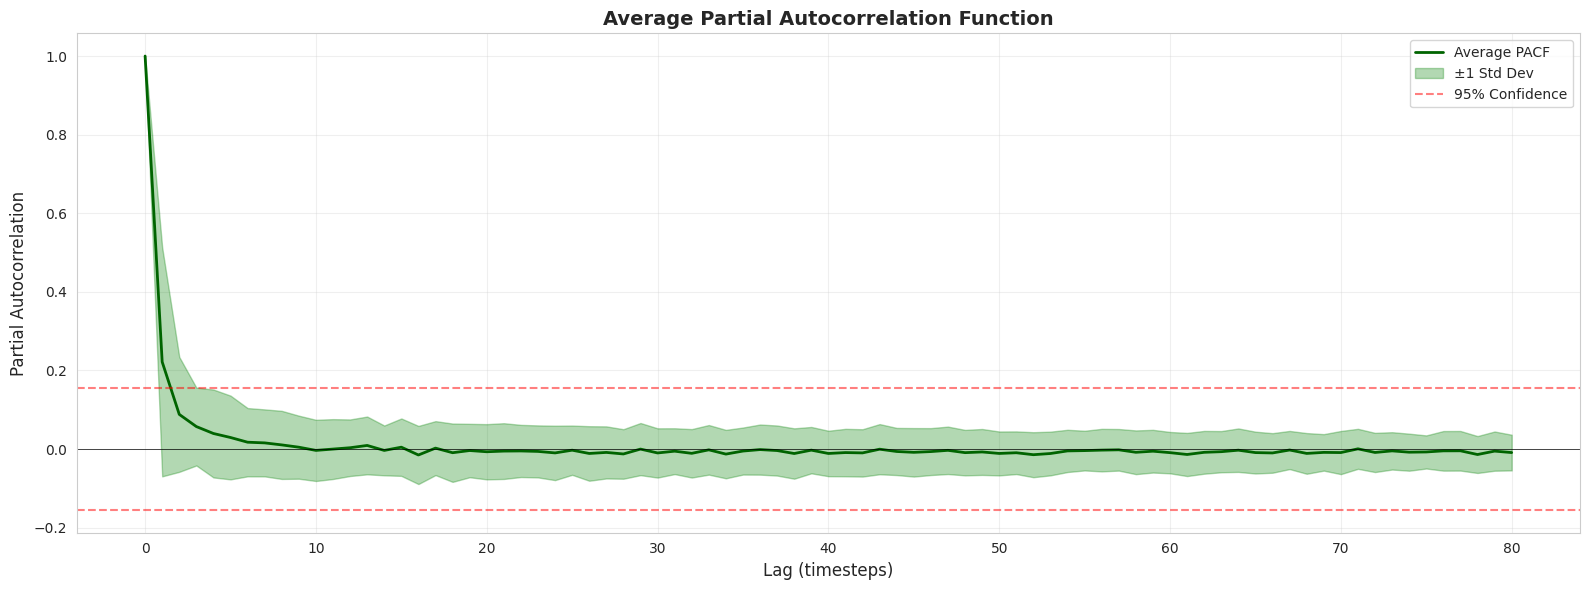


Significant PACF lags (above 95% confidence): [1]
Number of significant lags: 1


In [69]:
# Visualize PACF
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(lags, avg_pacf, linewidth=2, color='darkgreen', label='Average PACF')
ax.fill_between(lags, avg_pacf - std_pacf, avg_pacf + std_pacf, 
                 alpha=0.3, color='green', label='±1 Std Dev')

# Confidence interval
ax.axhline(y=confidence_interval, linestyle='--', color='red', alpha=0.5, label='95% Confidence')
ax.axhline(y=-confidence_interval, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=0, linestyle='-', color='black', linewidth=0.5)

ax.set_xlabel('Lag (timesteps)', fontsize=12)
ax.set_ylabel('Partial Autocorrelation', fontsize=12)
ax.set_title('Average Partial Autocorrelation Function', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find significant PACF lags
significant_pacf_lags = np.where(np.abs(avg_pacf[1:]) > confidence_interval)[0] + 1
print(f"\nSignificant PACF lags (above 95% confidence): {significant_pacf_lags[:10] if len(significant_pacf_lags) > 10 else significant_pacf_lags}")
print(f"Number of significant lags: {len(significant_pacf_lags)}")

### 3.5 Feature-Specific Autocorrelation Analysis

Let's examine individual features to see if different joints have different temporal patterns.

In [70]:
# Calculate ACF for each feature (averaged across samples)
feature_acf = {}

for joint_col in joint_cols:
    joint_acfs = [acf for key, acf in acf_results.items() if key[1] == joint_col]
    if joint_acfs:
        feature_acf[joint_col] = np.mean(joint_acfs, axis=0)

# Select top 8 features with highest variability in ACF
acf_variability = {joint: np.std(acf_vals[1:20]) for joint, acf_vals in feature_acf.items()}
top_features = sorted(acf_variability.items(), key=lambda x: x[1], reverse=True)[:8]

print("Top 8 features with most temporal variability:")
for i, (joint, var) in enumerate(top_features, 1):
    print(f"{i}. {joint}: Variability = {var:.4f}")

Top 8 features with most temporal variability:
1. joint_26: Variability = 0.1105
2. joint_27: Variability = 0.0978
3. joint_28: Variability = 0.0784
4. joint_29: Variability = 0.0758
5. joint_25: Variability = 0.0717
6. joint_02: Variability = 0.0691
7. joint_16: Variability = 0.0606
8. joint_23: Variability = 0.0548


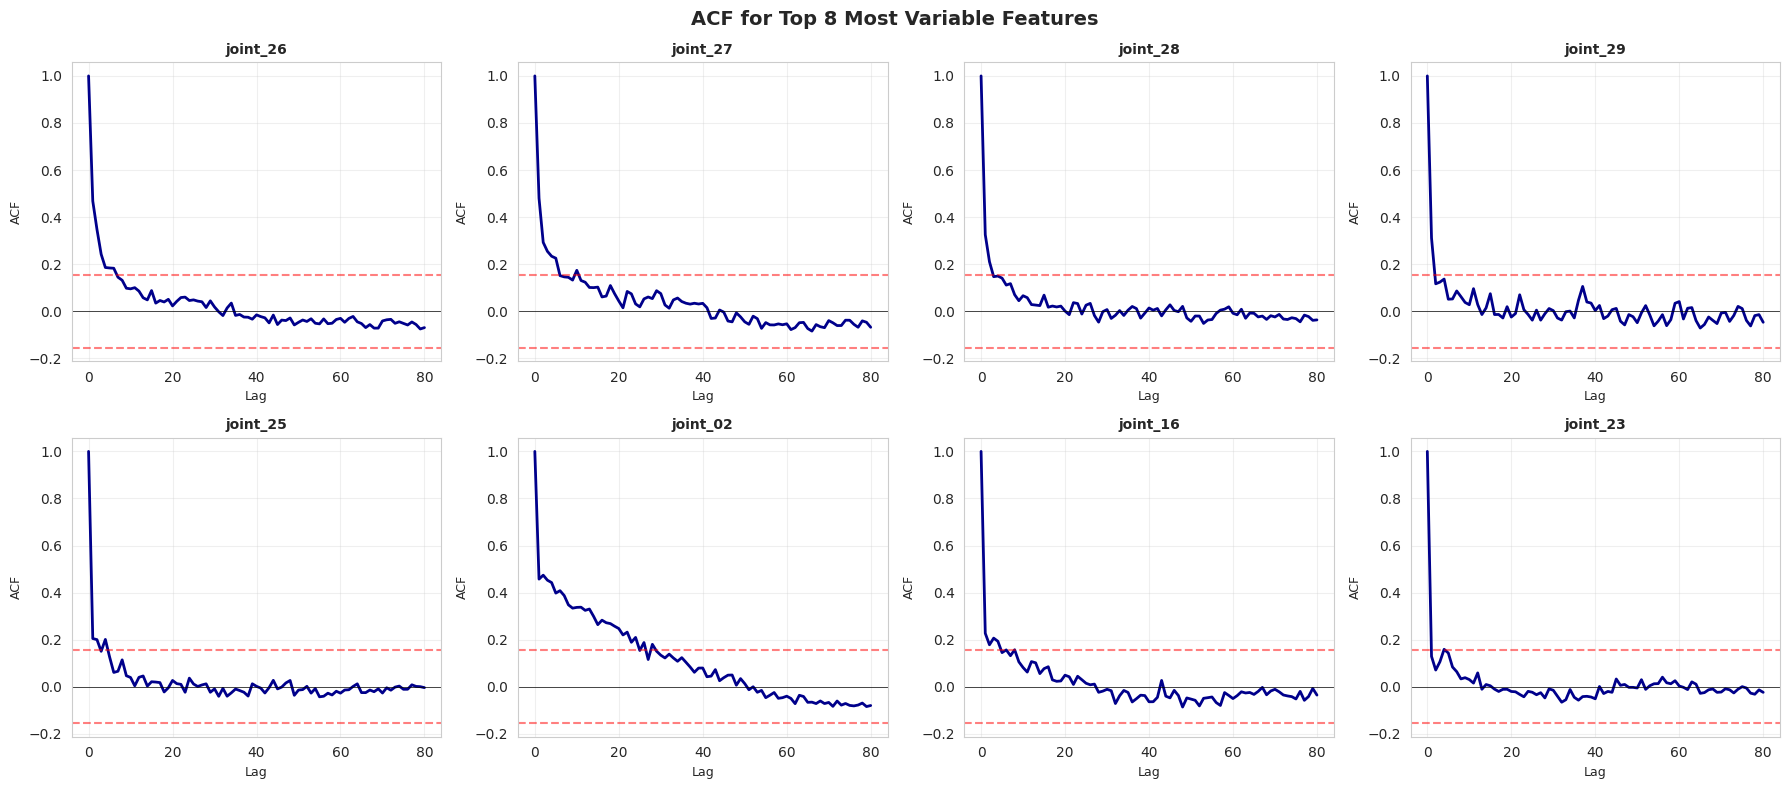

In [71]:
# Plot ACF for top features
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, (joint, _) in enumerate(top_features):
    ax = axes[idx]
    acf_vals = feature_acf[joint]
    
    ax.plot(lags, acf_vals, linewidth=2, color='darkblue')
    ax.axhline(y=confidence_interval, linestyle='--', color='red', alpha=0.5)
    ax.axhline(y=-confidence_interval, linestyle='--', color='red', alpha=0.5)
    ax.axhline(y=0, linestyle='-', color='black', linewidth=0.5)
    
    ax.set_xlabel('Lag', fontsize=9)
    ax.set_ylabel('ACF', fontsize=9)
    ax.set_title(f'{joint}', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('ACF for Top 8 Most Variable Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.6 Feature Correlation Analysis

We compute feature-to-feature correlations to identify redundant or strongly coupled joints. We use two complementary views:

- Per-sample aggregated correlation: compute each sample's mean per feature across timesteps, then compute Pearson correlation between features across samples (captures between-sample relationships).
- Global (row-wise) correlation: compute Pearson correlation across all timesteps and samples (captures instantaneous co-movement).

The analysis below shows clustermaps and heatmaps, and prints top positively / negatively correlated feature pairs.

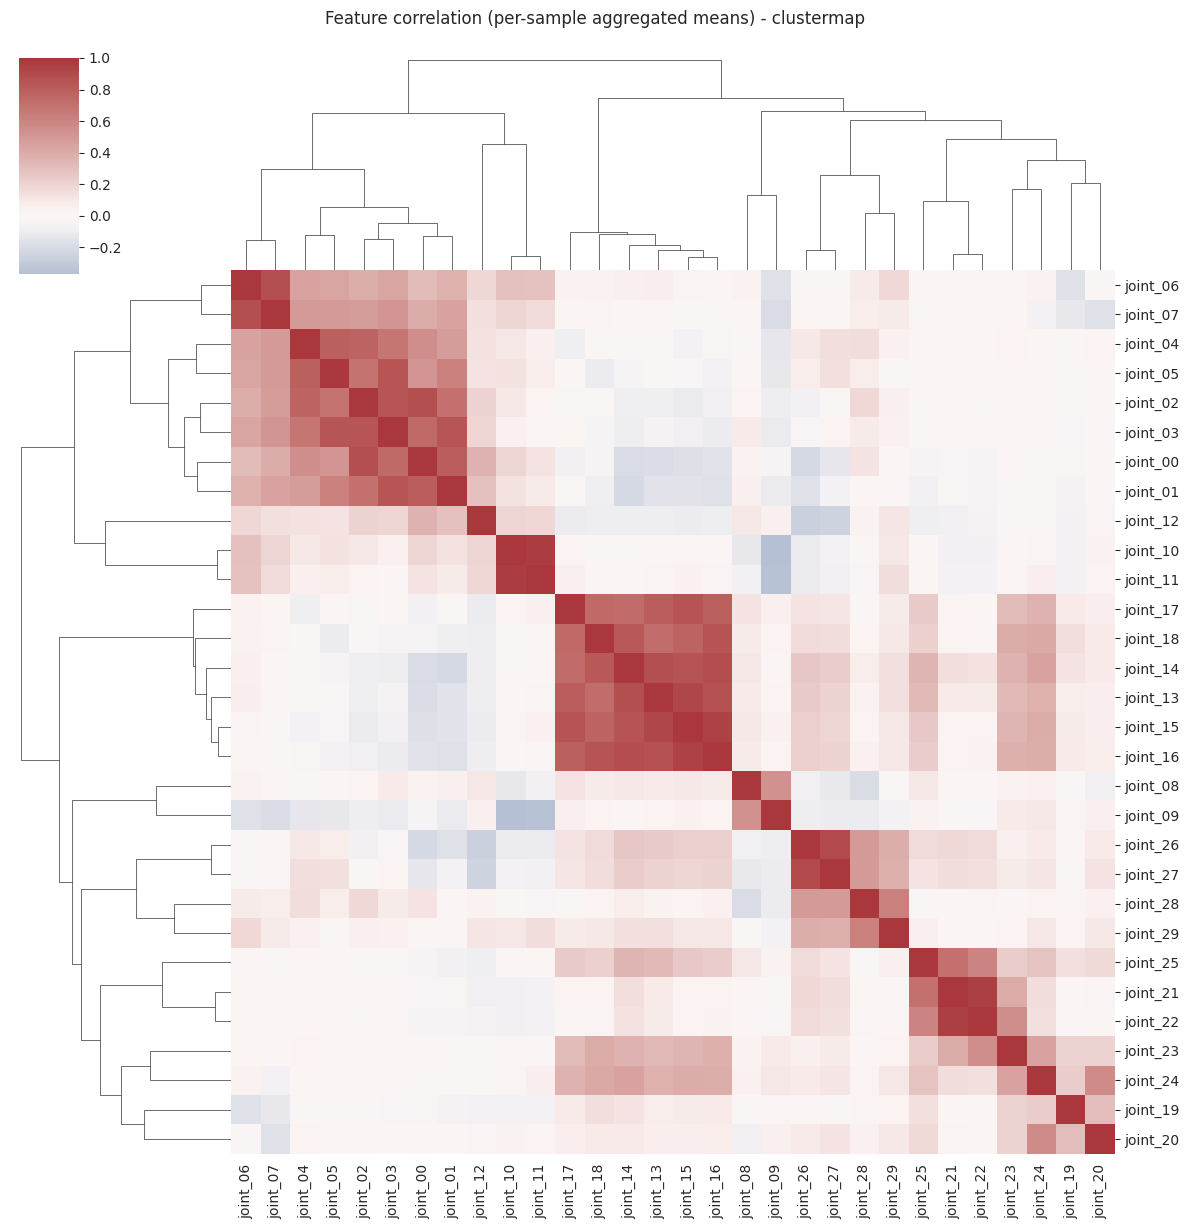

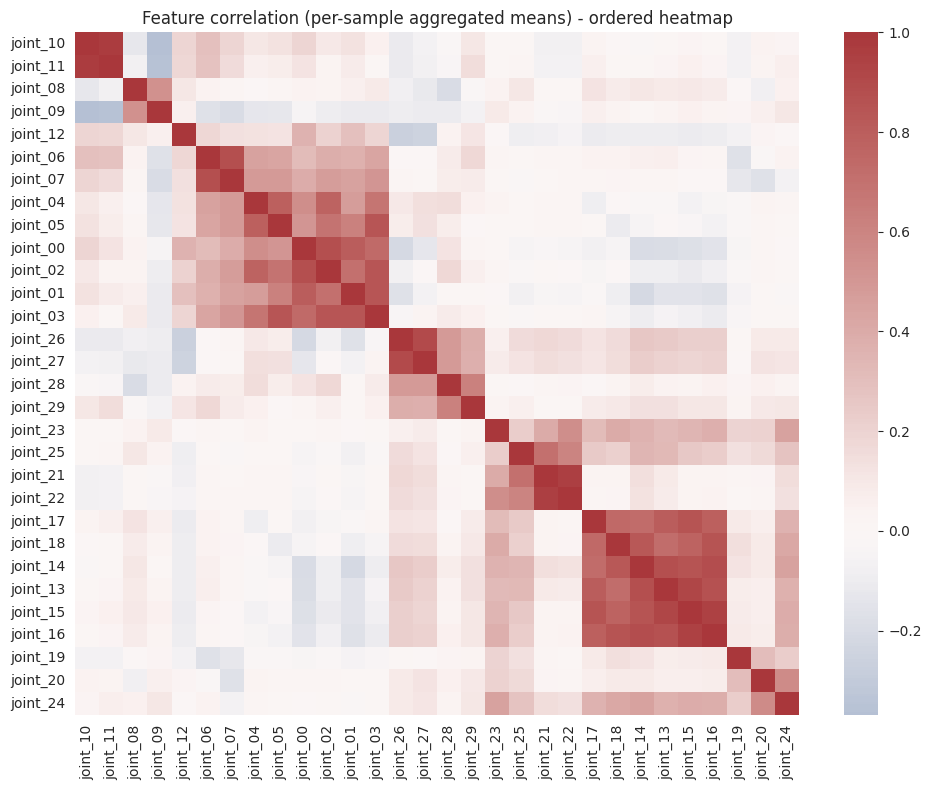

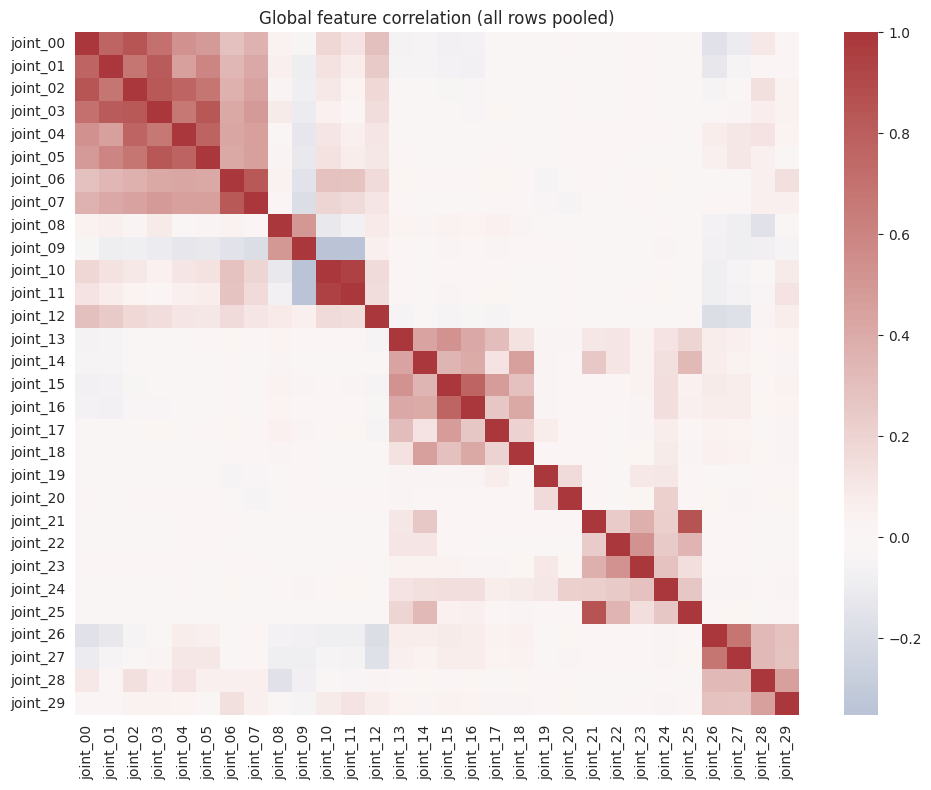


Top 10 positively correlated feature pairs (per-sample):
  joint_10 <-> joint_11: r = 0.969
  joint_21 <-> joint_22: r = 0.955
  joint_15 <-> joint_16: r = 0.952
  joint_13 <-> joint_15: r = 0.920
  joint_26 <-> joint_27: r = 0.901
  joint_14 <-> joint_16: r = 0.883
  joint_00 <-> joint_02: r = 0.880
  joint_13 <-> joint_14: r = 0.878
  joint_06 <-> joint_07: r = 0.873
  joint_13 <-> joint_16: r = 0.868

Top 10 negatively correlated feature pairs (per-sample):
  joint_09 <-> joint_10: r = -0.369
  joint_09 <-> joint_11: r = -0.359
  joint_12 <-> joint_26: r = -0.271
  joint_12 <-> joint_27: r = -0.252
  joint_01 <-> joint_14: r = -0.213
  joint_00 <-> joint_26: r = -0.210
  joint_08 <-> joint_28: r = -0.200
  joint_07 <-> joint_09: r = -0.197
  joint_00 <-> joint_14: r = -0.193
  joint_00 <-> joint_13: r = -0.188


In [72]:
# Feature correlation analysis

# 1) Per-sample aggregated feature means (samples x features)
agg = data.groupby('sample_index')[joint_cols].mean()

# Pearson correlation between features across samples
corr_per_sample = agg.corr()

# 2) Global row-wise correlation (all rows pooled)
global_corr = data[joint_cols].corr()

import scipy.cluster.hierarchy as sch

# Create clustered order for nicer plotting (use per-sample corr)
pairwise_dist = 1 - np.abs(corr_per_sample)
linkage = sch.linkage(sch.distance.squareform(pairwise_dist), method='average')
cluster_idx = sch.fcluster(linkage, t=0.7, criterion='distance')
# Create order by the linkage dendrogram
dendro = sch.dendrogram(linkage, no_plot=True)
order = dendro['leaves']

# Plot clustermap for per-sample correlation
sns.clustermap(corr_per_sample, row_cluster=True, col_cluster=True, cmap='vlag', 
               figsize=(12, 12), center=0, xticklabels=True, yticklabels=True)
plt.suptitle('Feature correlation (per-sample aggregated means) - clustermap', y=1.02)
plt.show()

# Plot heatmap (ordered)
plt.figure(figsize=(10, 8))
ordered_cols = [joint_cols[i] for i in order]
sns.heatmap(corr_per_sample.loc[ordered_cols, ordered_cols], cmap='vlag', center=0, 
            xticklabels=True, yticklabels=True)
plt.title('Feature correlation (per-sample aggregated means) - ordered heatmap')
plt.tight_layout()
plt.show()

# Plot global correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(global_corr, cmap='vlag', center=0)
plt.title('Global feature correlation (all rows pooled)')
plt.tight_layout()
plt.show()

# Identify top correlated / anti-correlated pairs (per-sample)
corr_mat = corr_per_sample.copy()
np.fill_diagonal(corr_mat.values, 0)
flat = []
for i in range(len(corr_mat)):
    for j in range(i+1, len(corr_mat)):
        flat.append((corr_mat.index[i], corr_mat.columns[j], corr_mat.iloc[i, j]))

flat_sorted_pos = sorted(flat, key=lambda x: x[2], reverse=True)
flat_sorted_neg = sorted(flat, key=lambda x: x[2])

print('\nTop 10 positively correlated feature pairs (per-sample):')
for a, b, v in flat_sorted_pos[:10]:
    print(f"  {a} <-> {b}: r = {v:.3f}")

print('\nTop 10 negatively correlated feature pairs (per-sample):')
for a, b, v in flat_sorted_neg[:10]:
    print(f"  {a} <-> {b}: r = {v:.3f}")

# Optional: show correlation of each feature with label (if label is numeric per-sample)
if 'label_encoded' in data.columns:
    label_per_sample = data.groupby('sample_index')['label_encoded'].first()
    corr_with_label = agg.corrwith(label_per_sample)
    corr_with_label = corr_with_label.sort_values(ascending=False)
    print('\nTop features correlated with label (per-sample):')
    print(corr_with_label.head(10))
    print('\nTop features anti-correlated with label (per-sample):')
    print(corr_with_label.tail(10))

### Feature correlation: summary & recommendations

- Key goals: identify pairs (or groups) of joints/features that are strongly correlated (redundant) or anti-correlated (opposite motion).
- Actionable outcomes:
  1. Strongly correlated features can be combined or one can be dropped to reduce model input dimension.
  2. Use grouped convolutions or channel-wise attention to let the model learn joint-group interactions.
  3. If a small set of features is highly predictive of the label (high correlation with label), consider feature selection to reduce overfitting and speed up training.

Notes:
- `per-sample` correlation uses sample-wise aggregated statistics (mean over time) and captures between-sample covariation (useful for feature selection).
- `global` correlation pools all timesteps and captures instantaneous co-movement (useful for identifying synchronous joints).

Next steps:
- If many features are redundant, create an ablation experiment removing top-k correlated features and measure CV performance.
- Consider PCA on per-sample aggregated features to get compact orthogonal components if many features are collinear.

If you want, I can now run the correlation cells and report the top pairs and show the clustermap output inline (requires executing cells).

## 4. Summary & Recommendations

Based on the autocorrelation analysis, we can make informed decisions about architecture hyperparameters.

In [73]:
print("=" * 80)
print("AUTOCORRELATION ANALYSIS SUMMARY & ARCHITECTURE RECOMMENDATIONS")
print("=" * 80)

print("\n📊 KEY FINDINGS:")
print("-" * 80)
print(f"1. Effective Memory Length: {effective_memory} timesteps")
print(f"   → Data shows temporal dependencies up to ~{effective_memory} steps back")
print(f"\n2. Negligible Correlation Point: {negligible_lag} timesteps")
print(f"   → Beyond this, past values have minimal direct influence")
print(f"\n3. Statistical Significance: {first_insignificant_lag} timesteps")
print(f"   → First lag where correlation becomes statistically insignificant")
print(f"\n4. Label Differences: {'Yes' if len(set([v[10] for v in avg_acf_by_label.values()])) > 1 else 'Minimal'}")
print(f"   → Different labels show distinct temporal patterns")

print("\n\n🏗️ ARCHITECTURE RECOMMENDATIONS:")
print("-" * 80)

print("\n1. CNN CONFIGURATION:")
print(f"   • Kernel sizes: 3, 5, 7, 9, 11")
print(f"     → Capture patterns from short (3) to medium (11) temporal scales")
print(f"   • Receptive field target: {negligible_lag}-{effective_memory} timesteps")
print(f"     → Stack 2-3 conv layers to achieve this receptive field")
print(f"   • Dilation rates: 1, 2, 4")
print(f"     → Use dilated convolutions for longer-range dependencies efficiently")

print("\n2. LSTM/GRU CONFIGURATION:")
print(f"   • Sequence length: Full 160 timesteps")
print(f"     → Use entire sequence to capture all temporal patterns")
print(f"   • Hidden state size: 64-128 units")
print(f"     → Based on effective memory of {effective_memory} and {len(joint_cols)} features")
print(f"   • Number of layers: 2-3 layers")
print(f"     → Multiple layers to capture hierarchical temporal patterns")

print("\n3. CNN-LSTM HYBRID:")
print(f"   • CNN front-end: 2 Conv1D layers (kernel=5-7)")
print(f"     → Extract local temporal features and reduce sequence length")
print(f"   • LSTM back-end: 1-2 LSTM layers (hidden=64-128)")
print(f"     → Model longer-range dependencies in CNN feature space")
print(f"   • Expected sequence reduction: 160 → ~40-80 timesteps after CNN")
print(f"     → More efficient LSTM processing with preserved information")

print("\n4. ATTENTION MECHANISMS:")
print(f"   • Attention window: {negligible_lag}-{effective_memory} timesteps")
print(f"     → Focus attention on most correlated time steps")
print(f"   • Multi-head attention: 4-8 heads")
print(f"     → Capture different temporal patterns simultaneously")

print("\n\n💡 MODELING INSIGHTS:")
print("-" * 80)
print(f"• Short-term patterns (3-10 steps) are strong → CNN with small kernels")
print(f"• Medium-term dependencies ({negligible_lag}-{effective_memory} steps) exist → LSTM or stacked CNNs")
print(f"• Long-term memory beyond {effective_memory} steps is weak → may not need very deep networks")
print(f"• ACF variance is high → diverse temporal patterns → need regularization (dropout)")

print("\n" + "=" * 80)

AUTOCORRELATION ANALYSIS SUMMARY & ARCHITECTURE RECOMMENDATIONS

📊 KEY FINDINGS:
--------------------------------------------------------------------------------
1. Effective Memory Length: 66 timesteps
   → Data shows temporal dependencies up to ~66 steps back

2. Negligible Correlation Point: 13 timesteps
   → Beyond this, past values have minimal direct influence

3. Statistical Significance: 5 timesteps
   → First lag where correlation becomes statistically insignificant

4. Label Differences: Yes
   → Different labels show distinct temporal patterns


🏗️ ARCHITECTURE RECOMMENDATIONS:
--------------------------------------------------------------------------------

1. CNN CONFIGURATION:
   • Kernel sizes: 3, 5, 7, 9, 11
     → Capture patterns from short (3) to medium (11) temporal scales
   • Receptive field target: 13-66 timesteps
     → Stack 2-3 conv layers to achieve this receptive field
   • Dilation rates: 1, 2, 4
     → Use dilated convolutions for longer-range dependencies

## 5. CNN-LSTM Hybrid Model Implementation

Now let's implement a CNN-LSTM hybrid architecture with:
- CNN front-end for local feature extraction
- LSTM back-end for temporal modeling
- Grid search for hyperparameter optimization
- 5-fold cross-validation
- Training on full dataset with best parameters
- Test set prediction for submission

### 5.1 Import PyTorch and Setup

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import itertools
from tqdm.auto import tqdm

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed(42)
elif torch.mps.is_available():
    device = torch.device('mps')
    torch.mps.manual_seed(42)
else:
    device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


### 5.2 Prepare Data

**Important:** This section now includes additional features beyond just joints:
- **Joint features** (`joint_0` to `joint_29`, excluding `joint_30`): 30 features - **NORMALIZED**
- **Additional features**: `time`, `is_pirate`, `pain_survey_*` - **NOT NORMALIZED**

**Feature Engineering:**
- `is_pirate` is derived from `n_legs`, `n_hands`, `n_eyes`: If all equal 2 → not pirate (0), otherwise → pirate (1)
- Original `n_legs`, `n_hands`, `n_eyes` columns are dropped after creating `is_pirate`

The `TimeSeriesDataset` class applies StandardScaler **only to joint features**, keeping additional features in their original scale. This is important because:
- Joint angles benefit from normalization (different scales, units)
- Binary/categorical features (like `is_pirate`) should remain unnormalized (already 0/1)
- Time feature may have meaningful scale that shouldn't be lost

Total features will be 30+ depending on how many `pain_survey_*` columns exist in the data.

In [75]:
# Reload and prepare full dataset
train_data = pd.read_csv('../data/pirate_pain_train.csv')
train_labels = pd.read_csv('../data/pirate_pain_train_labels.csv')
test_data = pd.read_csv('../data/pirate_pain_test.csv')

# Merge training data
full_data = train_data.merge(train_labels, on='sample_index')

# Drop joint_30 (constant feature)
if 'joint_30' in full_data.columns:
    full_data = full_data.drop(columns=['joint_30'])
if 'joint_30' in test_data.columns:
    test_data = test_data.drop(columns=['joint_30'])

# Create is_pirate feature from n_legs, n_hands, n_eyes
# If person has 2 legs, 2 hands, 2 eyes -> not a pirate (0)
# Otherwise -> is a pirate (1)
full_data['is_pirate'] = ((full_data['n_legs'] != 2) | 
                          (full_data['n_hands'] != 2) | 
                          (full_data['n_eyes'] != 2)).astype(int)

test_data['is_pirate'] = ((test_data['n_legs'] != 2) | 
                          (test_data['n_hands'] != 2) | 
                          (test_data['n_eyes'] != 2)).astype(int)

# Drop the original n_legs, n_hands, n_eyes columns
full_data = full_data.drop(columns=['n_legs', 'n_hands', 'n_eyes'])
test_data = test_data.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

print(f"Created is_pirate feature:")
print(f"  Training set - Pirates: {full_data['is_pirate'].sum()}, Non-pirates: {(full_data['is_pirate'] == 0).sum()}")
print(f"  Test set - Pirates: {test_data['is_pirate'].sum()}, Non-pirates: {(test_data['is_pirate'] == 0).sum()}")

# Get feature columns - include joint features AND additional useful features
joint_cols = [col for col in full_data.columns if col.startswith('joint_')]
additional_cols = ['time', 'is_pirate']
# Add pain_survey columns
pain_survey_cols = [col for col in full_data.columns if col.startswith('pain_survey_')]
additional_cols.extend(pain_survey_cols)

# Filter to only columns that exist in the data
additional_cols = [col for col in additional_cols if col in full_data.columns and col in test_data.columns]

# Combine all feature columns
feature_cols = joint_cols + additional_cols
n_features = len(feature_cols)
n_joint_features = len(joint_cols)
n_additional_features = len(additional_cols)
n_timesteps = 160

print(f"Number of joint features: {n_joint_features}")
print(f"Number of additional features: {n_additional_features} {additional_cols}")
print(f"Total features: {n_features}")
print(f"Number of timesteps: {n_timesteps}")
print(f"Number of training samples: {full_data['sample_index'].nunique()}")
print(f"Number of test samples: {test_data['sample_index'].nunique()}")

# Encode labels
label_encoder = LabelEncoder()
full_data['label_encoded'] = label_encoder.fit_transform(full_data['label'])
n_classes = len(label_encoder.classes_)

print(f"\nClasses: {label_encoder.classes_}")
print(f"Number of classes: {n_classes}")
print(f"\nClass distribution:")
print(full_data.groupby('sample_index')['label'].first().value_counts())

Created is_pirate feature:
  Training set - Pirates: 105760, Non-pirates: 0
  Test set - Pirates: 211840, Non-pirates: 0
Number of joint features: 30
Number of additional features: 6 ['time', 'is_pirate', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
Total features: 36
Number of timesteps: 160
Number of training samples: 661
Number of test samples: 1324

Classes: ['high_pain' 'low_pain' 'no_pain']
Number of classes: 3

Class distribution:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64


In [90]:
# Create 3D arrays for training (samples, timesteps, features)
def create_sequences(data, feature_cols, window_size=80, stride=20, use_sliding_window=True):
    """
    Convert dataframe to 3D array (samples, timesteps, features)
    
    Args:
        data: DataFrame with time series data
        feature_cols: list of feature column names
        window_size: size of the sliding window (default: 80 timesteps)
        stride: step size for sliding window (default: 20 timesteps)
        use_sliding_window: if True, use sliding window; if False, use full sequence
    
    Returns:
        X: array of shape (n_sequences, window_size, n_features)
        y: array of labels (if available)
        sample_indices: list of original sample indices for each sequence
    """
    sequences = []
    labels = []
    sample_indices = []
    
    for sample_idx in data['sample_index'].unique():
        sample_data = data[data['sample_index'] == sample_idx]
        
        # Get features (timesteps x features)
        full_sequence = sample_data[feature_cols].values  # Shape: (160, n_features)
        
        if use_sliding_window:
            # Apply sliding window to create multiple sequences per sample
            n_timesteps = len(full_sequence)
            
            # Generate all possible windows
            for start_idx in range(0, n_timesteps - window_size + 1, stride):
                end_idx = start_idx + window_size
                window = full_sequence[start_idx:end_idx]
                sequences.append(window)
                
                # Get label (same for all windows from this sample)
                if 'label_encoded' in sample_data.columns:
                    label = sample_data['label_encoded'].iloc[0]
                    labels.append(label)
                
                sample_indices.append(sample_idx)
        else:
            # Use full sequence (original behavior)
            sequences.append(full_sequence)
            
            if 'label_encoded' in sample_data.columns:
                label = sample_data['label_encoded'].iloc[0]
                labels.append(label)
            
            sample_indices.append(sample_idx)
    
    X = np.array(sequences)  # Shape: (n_sequences, window_size, n_features)
    
    if labels:
        y = np.array(labels)  # Shape: (n_sequences,)
        return X, y, sample_indices
    else:
        return X, None, sample_indices

# Configure sliding window parameters
window_size = 18  # Use 80 timesteps instead of 160
stride = 10       # Move window by 20 timesteps (75% overlap)
use_sliding_window = True  # Set to False to use full 160 timesteps

print(f"Sliding window configuration:")
print(f"  Window size: {window_size} timesteps")
print(f"  Stride: {stride} timesteps")
print(f"  Overlap: {(window_size - stride) / window_size * 100:.1f}%")
print(f"  Expected windows per sample: {(160 - window_size) // stride + 1}")

X_train_full, y_train_full, train_sample_indices = create_sequences(
    full_data, feature_cols, window_size=window_size, stride=stride, use_sliding_window=use_sliding_window
)
X_test, _, test_sample_indices = create_sequences(
    test_data, feature_cols, window_size=window_size, stride=stride, use_sliding_window=use_sliding_window
)

print(f"\nX_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nData augmentation factor: {X_train_full.shape[0] / full_data['sample_index'].nunique():.1f}x")

Sliding window configuration:
  Window size: 18 timesteps
  Stride: 10 timesteps
  Overlap: 44.4%
  Expected windows per sample: 15

X_train shape: (9915, 18, 36)
y_train shape: (9915,)
X_test shape: (19860, 18, 36)

Data augmentation factor: 15.0x

X_train shape: (9915, 18, 36)
y_train shape: (9915,)
X_test shape: (19860, 18, 36)

Data augmentation factor: 15.0x


**Sliding Window Enhancement:**

The `create_sequences` function now supports sliding window generation:
- **Original approach**: Each sample generates 1 sequence of 160 timesteps
- **Sliding window approach**: Each sample generates multiple overlapping sequences

Benefits:
1. **Data augmentation**: More training samples from the same data
2. **Shorter sequences**: Faster training and lower memory usage
3. **Better generalization**: Model learns from different temporal segments
4. **Flexible window size**: Based on autocorrelation analysis (recommended: 40-80 timesteps)

Parameters:
- `window_size`: Length of each sequence (e.g., 80 timesteps)
- `stride`: Step size between windows (e.g., 20 timesteps = 75% overlap)
- `use_sliding_window`: Toggle between sliding window and full sequence mode

### 5.3 Define PyTorch Dataset

In [91]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series data"""
    
    def __init__(self, X, y=None, scaler=None, fit_scaler=False, n_joint_features=None):
        """
        Args:
            X: numpy array of shape (n_samples, n_timesteps, n_features)
               Features are ordered: [joint_features, additional_features]
            y: numpy array of shape (n_samples,) - labels (optional for test set)
            scaler: StandardScaler instance (optional)
            fit_scaler: whether to fit the scaler on this data
            n_joint_features: number of joint features (only these will be normalized)
        """
        self.X = X.copy()
        self.y = y
        self.n_joint_features = n_joint_features
        
        # Normalize ONLY joint features (first n_joint_features columns)
        if fit_scaler or scaler is not None:
            n_samples, n_timesteps, n_features = X.shape
            
            if n_joint_features is not None and n_joint_features < n_features:
                # Split joint and additional features
                X_joint = X[:, :, :n_joint_features]
                X_additional = X[:, :, n_joint_features:]
                
                # Reshape joint features for scaling
                X_joint_reshaped = X_joint.reshape(-1, n_joint_features)
                
                if fit_scaler:
                    self.scaler = StandardScaler()
                    X_joint_scaled = self.scaler.fit_transform(X_joint_reshaped)
                else:
                    self.scaler = scaler
                    X_joint_scaled = self.scaler.transform(X_joint_reshaped)
                
                # Reshape back
                X_joint_scaled = X_joint_scaled.reshape(n_samples, n_timesteps, n_joint_features)
                
                # Concatenate scaled joint features with unnormalized additional features
                self.X = np.concatenate([X_joint_scaled, X_additional], axis=2)
            else:
                # Normalize all features (fallback to old behavior)
                X_reshaped = X.reshape(-1, n_features)
                
                if fit_scaler:
                    self.scaler = StandardScaler()
                    X_scaled = self.scaler.fit_transform(X_reshaped)
                else:
                    self.scaler = scaler
                    X_scaled = self.scaler.transform(X_reshaped)
                
                self.X = X_scaled.reshape(n_samples, n_timesteps, n_features)
        else:
            self.scaler = None
        
        # Convert to PyTorch tensors
        self.X = torch.FloatTensor(self.X)
        if self.y is not None:
            self.y = torch.LongTensor(self.y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

print("TimeSeriesDataset class defined!")

TimeSeriesDataset class defined!


### 5.4 Define CNN-LSTM Hybrid Model

In [92]:
class CNN_LSTM(nn.Module):
    """CNN-LSTM Hybrid with Multi-Head Attention for time series classification"""
    
    def __init__(self, n_features, n_classes, 
                 cnn_filters=64, cnn_kernel=5, cnn_layers=2,
                 lstm_hidden=64, lstm_layers=2, 
                 dropout=0.5, n_heads=4, use_attention=True):
        """
        Args:
            n_features: number of input features
            n_classes: number of output classes
            cnn_filters: number of filters in CNN layers
            cnn_kernel: kernel size for CNN
            cnn_layers: number of CNN blocks
            lstm_hidden: LSTM hidden size
            lstm_layers: number of LSTM layers
            dropout: dropout rate
            n_heads: number of attention heads
            use_attention: whether to use multi-head attention
        """
        super(CNN_LSTM, self).__init__()
        
        self.n_features = n_features
        self.n_classes = n_classes
        self.use_attention = use_attention
        
        # Input embedding layer (projects features to embedding dimension)
        self.input_embedding = nn.Linear(n_features, cnn_filters)
        
        # Positional encoding (learnable)
        # Set max_seq_len to support both full sequences and sliding windows
        self.max_seq_len = 160  # Maximum possible sequence length
        self.positional_embedding = nn.Parameter(torch.randn(1, self.max_seq_len, cnn_filters))
        
        # CNN Front-end (for local feature extraction)
        cnn_blocks = []
        in_channels = cnn_filters
        
        for i in range(cnn_layers):
            out_channels = cnn_filters * (2 ** i)  # Double filters each layer
            cnn_blocks.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=cnn_kernel, padding=cnn_kernel//2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_channels = out_channels
        
        self.cnn = nn.Sequential(*cnn_blocks)
        
        # LSTM Back-end (for temporal modeling)
        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Multi-Head Attention (optional)
        if self.use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_hidden * 2,  # *2 for bidirectional LSTM
                num_heads=n_heads,
                dropout=dropout,
                batch_first=True
            )
            self.attention_norm = nn.LayerNorm(lstm_hidden * 2)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden * 2, lstm_hidden),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, n_classes)
        )
    
    def forward(self, x):
        """
        Args:
            x: (batch, timesteps, features)
        Returns:
            output: (batch, n_classes)
        """
        batch_size, seq_len, _ = x.shape
        
        # Input embedding
        x = self.input_embedding(x)  # (batch, timesteps, cnn_filters)
        
        # Add positional encoding
        x = x + self.positional_embedding[:, :seq_len, :]
        
        # CNN expects (batch, features, timesteps)
        x = x.transpose(1, 2)
        
        # Apply CNN
        x = self.cnn(x)
        
        # Transpose back for LSTM: (batch, timesteps, features)
        x = x.transpose(1, 2)
        
        # Apply LSTM
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Apply Multi-Head Attention
        if self.use_attention:
            # Self-attention over sequence
            attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
            
            # Residual connection + Layer normalization
            lstm_out = self.attention_norm(lstm_out + attn_out)
        
        # Use last timestep output
        x = lstm_out[:, -1, :]
        
        # Fully connected layers
        output = self.fc(x)
        
        return output

# Test model instantiation
model_test = CNN_LSTM(n_features=n_features, n_classes=n_classes, 
                      n_heads=4, use_attention=True)
print(f"Model created successfully!")
print(f"\nModel architecture:")
print(model_test)
print(f"\nTotal parameters: {sum(p.numel() for p in model_test.parameters()):,}")
print(f"\nKey enhancements:")
print(f"  • Input embedding layer: projects {n_features} features to embedding space")
print(f"  • Positional embeddings: learnable position encodings for temporal context")
print(f"  • Multi-head attention: 4 heads for capturing different temporal patterns")
print(f"  • Residual connections: skip connections around attention layer")

Model created successfully!

Model architecture:
CNN_LSTM(
  (input_embedding): Linear(in_features=36, out_features=64, bias=True)
  (cnn): Sequential(
    (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5,

### 5.5 Define Training and Evaluation Functions

In [93]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Predictions
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, f1, acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, f1, acc, all_preds, all_labels


def train_model(model, train_loader, val_loader, criterion, optimizer, 
                n_epochs, device, patience=20, verbose=True):
    """Train model with early stopping"""
    best_val_f1 = 0
    patience_counter = 0
    history = {
        'train_loss': [], 'train_f1': [], 'train_acc': [],
        'val_loss': [], 'val_f1': [], 'val_acc': []
    }
    
    for epoch in range(n_epochs):
        # Train
        train_loss, train_f1, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_f1, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_acc'].append(val_acc)
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | "
                  f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}")
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, history, best_val_f1

print("Training functions defined!")

Training functions defined!


### 5.6 Grid Search with 5-Fold Cross-Validation

In [94]:
# Define hyperparameter grid
# param_grid = {
#     'cnn_filters': [64, 128],
#     'cnn_kernel': [5, 7],
#     'cnn_layers': [2],
#     'lstm_hidden': [64, 128],
#     'lstm_layers': [2],
#     'dropout': [0.4, 0.5],
#     'lr': [1e-3, 1e-4],
#     'batch_size': [16, 32],
#     'n_heads': [4, 8],
#     'use_attention': [True, False]
# }
# Quick test parameter grid - one configuration for fast testing
param_grid = {
    'cnn_filters': [64],
    'cnn_kernel': [5],
    'cnn_layers': [2],
    'lstm_hidden': [128],
    'lstm_layers': [2],
    'dropout': [0.3],
    'lr': [1e-4],
    'batch_size': [64],
    'n_heads': [4],
    'use_attention': [True]
}

# Generate all combinations
param_combinations = [dict(zip(param_grid.keys(), v)) 
                     for v in itertools.product(*param_grid.values())]

print(f"Total hyperparameter combinations: {len(param_combinations)}")
print(f"\nExample configurations:")
for i, params in enumerate(param_combinations[:3]):
    print(f"\nConfig {i+1}:")
    for k, v in params.items():
        print(f"  {k}: {v}")

Total hyperparameter combinations: 1

Example configurations:

Config 1:
  cnn_filters: 64
  cnn_kernel: 5
  cnn_layers: 2
  lstm_hidden: 128
  lstm_layers: 2
  dropout: 0.3
  lr: 0.0001
  batch_size: 64
  n_heads: 4
  use_attention: True


In [95]:
# Grid search with K-Fold CV
def grid_search_cv(X, y, param_combinations, n_splits=5, n_epochs=100, patience=20):
    """Perform grid search with cross-validation"""
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    print(f"Starting grid search with {len(param_combinations)} configurations and {n_splits}-fold CV...")
    print(f"Total training runs: {len(param_combinations) * n_splits}\n")
    
    for config_idx, params in enumerate(param_combinations):
        print(f"\n{'='*80}")
        print(f"Configuration {config_idx + 1}/{len(param_combinations)}")
        print(f"{'='*80}")
        for k, v in params.items():
            print(f"  {k}: {v}")
        
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\n  Fold {fold + 1}/{n_splits}...")
            
            # Split data
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Create datasets with scaling (only normalize joint features)
            train_dataset = TimeSeriesDataset(X_train, y_train, fit_scaler=True, n_joint_features=n_joint_features)
            val_dataset = TimeSeriesDataset(X_val, y_val, scaler=train_dataset.scaler, n_joint_features=n_joint_features)
            
            # Create dataloaders
            train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], 
                                     shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], 
                                   shuffle=False, num_workers=0)
            
            # Create model
            model = CNN_LSTM(
                n_features=n_features,
                n_classes=n_classes,
                cnn_filters=params['cnn_filters'],
                cnn_kernel=params['cnn_kernel'],
                cnn_layers=params['cnn_layers'],
                lstm_hidden=params['lstm_hidden'],
                lstm_layers=params['lstm_layers'],
                dropout=params['dropout'],
                n_heads=params.get('n_heads', 4),
                use_attention=params.get('use_attention', True)
            ).to(device)
            
            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=params['lr'])
            
            # Train
            model, history, best_f1 = train_model(
                model, train_loader, val_loader, criterion, optimizer,
                n_epochs=n_epochs, device=device, patience=patience, verbose=False
            )
            
            fold_scores.append(best_f1)
            print(f"    Best Val F1: {best_f1:.4f}")
        
        # Store results
        mean_f1 = np.mean(fold_scores)
        std_f1 = np.std(fold_scores)
        
        results.append({
            'params': params,
            'fold_scores': fold_scores,
            'mean_f1': mean_f1,
            'std_f1': std_f1
        })
        
        print(f"\n  Average F1: {mean_f1:.4f} ± {std_f1:.4f}")
    
    return results

print("Grid search function defined!")

Grid search function defined!


In [96]:
# Run grid search (this will take a while!)
print("Starting grid search... This may take 30-60 minutes depending on hardware.\n")

results = grid_search_cv(
    X_train_full, 
    y_train_full, 
    param_combinations,
    n_splits=5,
    n_epochs=100,
    patience=20
)

print("\n" + "="*80)
print("GRID SEARCH COMPLETE!")
print("="*80)

Starting grid search... This may take 30-60 minutes depending on hardware.

Starting grid search with 1 configurations and 5-fold CV...
Total training runs: 5


Configuration 1/1
  cnn_filters: 64
  cnn_kernel: 5
  cnn_layers: 2
  lstm_hidden: 128
  lstm_layers: 2
  dropout: 0.3
  lr: 0.0001
  batch_size: 64
  n_heads: 4
  use_attention: True

  Fold 1/5...
    Best Val F1: 0.9604

  Fold 2/5...
    Best Val F1: 0.9604

  Fold 2/5...
    Best Val F1: 0.9694

  Fold 3/5...
    Best Val F1: 0.9694

  Fold 3/5...
    Best Val F1: 0.9527

  Fold 4/5...
    Best Val F1: 0.9527

  Fold 4/5...
    Best Val F1: 0.9704

  Fold 5/5...
    Best Val F1: 0.9704

  Fold 5/5...
    Best Val F1: 0.9633

  Average F1: 0.9632 ± 0.0065

GRID SEARCH COMPLETE!
    Best Val F1: 0.9633

  Average F1: 0.9632 ± 0.0065

GRID SEARCH COMPLETE!


### 5.7 Analyze Grid Search Results

In [99]:
# Sort results by mean F1 score
results_sorted = sorted(results, key=lambda x: x['mean_f1'], reverse=True)

print("="*80)
print("TOP 5 CONFIGURATIONS")
print("="*80)

for i, result in enumerate(results_sorted[:5]):
    print(f"\n{'='*80}")
    print(f"Rank {i+1}: Mean F1 = {result['mean_f1']:.4f} ± {result['std_f1']:.4f}")
    print(f"{'='*80}")
    print("Parameters:")
    for k, v in result['params'].items():
        print(f"  {k}: {v}")
    print(f"\nFold scores: {[f'{s:.4f}' for s in result['fold_scores']]}")

# Best configuration
best_config = results_sorted[0]
best_params = best_config['params']

print("\n" + "="*80)
print("BEST CONFIGURATION")
print("="*80)
print(f"Mean F1: {best_config['mean_f1']:.4f} ± {best_config['std_f1']:.4f}")
print("\nBest parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

TOP 5 CONFIGURATIONS

Rank 1: Mean F1 = 0.9632 ± 0.0065
Parameters:
  cnn_filters: 64
  cnn_kernel: 5
  cnn_layers: 2
  lstm_hidden: 128
  lstm_layers: 2
  dropout: 0.3
  lr: 0.0001
  batch_size: 64
  n_heads: 4
  use_attention: True

Fold scores: ['0.9604', '0.9694', '0.9527', '0.9704', '0.9633']

BEST CONFIGURATION
Mean F1: 0.9632 ± 0.0065

Best parameters:
  cnn_filters: 64
  cnn_kernel: 5
  cnn_layers: 2
  lstm_hidden: 128
  lstm_layers: 2
  dropout: 0.3
  lr: 0.0001
  batch_size: 64
  n_heads: 4
  use_attention: True


### 5.8 Train Final Model on Full Dataset

In [100]:
# # Just set some hard coded params by hand for now
# best_params = {
#     'cnn_filters': 64,
#     'cnn_kernel': 5,
#     'cnn_layers': 2,
#     'lstm_hidden': 128,
#     'lstm_layers': 2,
#     'dropout': 0.5,
#     'lr': 1e-3,
#     'batch_size': 32
# }

# print("Best parameters set manually for testing:")
# for k, v in best_params.items():
#     print(f"  {k}: {v}")

In [101]:
print("Training final model on full dataset with best hyperparameters...")
print("="*80)

# Create full dataset with scaling (only normalize joint features)
final_train_dataset = TimeSeriesDataset(X_train_full, y_train_full, fit_scaler=True, n_joint_features=n_joint_features)
final_train_loader = DataLoader(final_train_dataset, batch_size=best_params['batch_size'], 
                                shuffle=True, num_workers=0)

# Create final model
final_model = CNN_LSTM(
    n_features=n_features,
    n_classes=n_classes,
    cnn_filters=best_params['cnn_filters'],
    cnn_kernel=best_params['cnn_kernel'],
    cnn_layers=best_params['cnn_layers'],
    lstm_hidden=best_params['lstm_hidden'],
    lstm_layers=best_params['lstm_layers'],
    dropout=best_params['dropout'],
    n_heads=best_params.get('n_heads', 4),
    use_attention=best_params.get('use_attention', True)
).to(device)

print(f"\nFinal model parameters: {sum(p.numel() for p in final_model.parameters()):,}")
print(f"Using multi-head attention: {best_params.get('use_attention', True)} "
      f"(heads: {best_params.get('n_heads', 4)})")

# Loss and optimizer
final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])

# Train on full dataset (no validation set, so we use more epochs)
final_model.train()
n_epochs_final = 150
history_final = {'train_loss': [], 'train_f1': [], 'train_acc': []}

print(f"\nTraining for {n_epochs_final} epochs on full dataset...")

for epoch in range(n_epochs_final):
    train_loss, train_f1, train_acc = train_epoch(
        final_model, final_train_loader, final_criterion, final_optimizer, device
    )
    
    history_final['train_loss'].append(train_loss)
    history_final['train_f1'].append(train_f1)
    history_final['train_acc'].append(train_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs_final} | "
              f"Loss: {train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")

print("\n" + "="*80)
print("FINAL MODEL TRAINING COMPLETE!")
print("="*80)
print(f"Final Training F1: {history_final['train_f1'][-1]:.4f}")
print(f"Final Training Accuracy: {history_final['train_acc'][-1]:.4f}")

Training final model on full dataset with best hyperparameters...

Final model parameters: 1,031,043
Using multi-head attention: True (heads: 4)

Training for 150 epochs on full dataset...
Epoch 10/150 | Loss: 0.3551, F1: 0.7061, Acc: 0.8650
Epoch 20/150 | Loss: 0.1976, F1: 0.8489, Acc: 0.9297
Epoch 30/150 | Loss: 0.1448, F1: 0.8939, Acc: 0.9496
Epoch 40/150 | Loss: 0.1097, F1: 0.9161, Acc: 0.9603
Epoch 50/150 | Loss: 0.0888, F1: 0.9348, Acc: 0.9688
Epoch 60/150 | Loss: 0.0758, F1: 0.9426, Acc: 0.9716
Epoch 70/150 | Loss: 0.0553, F1: 0.9622, Acc: 0.9810
Epoch 80/150 | Loss: 0.0523, F1: 0.9607, Acc: 0.9800
Epoch 90/150 | Loss: 0.0455, F1: 0.9650, Acc: 0.9820
Epoch 100/150 | Loss: 0.0508, F1: 0.9631, Acc: 0.9815
Epoch 110/150 | Loss: 0.0423, F1: 0.9657, Acc: 0.9825
Epoch 120/150 | Loss: 0.0356, F1: 0.9718, Acc: 0.9862
Epoch 130/150 | Loss: 0.0373, F1: 0.9735, Acc: 0.9868
Epoch 140/150 | Loss: 0.0317, F1: 0.9752, Acc: 0.9880
Epoch 150/150 | Loss: 0.0302, F1: 0.9775, Acc: 0.9887

FINAL MOD

### 5.9 Visualize Training History

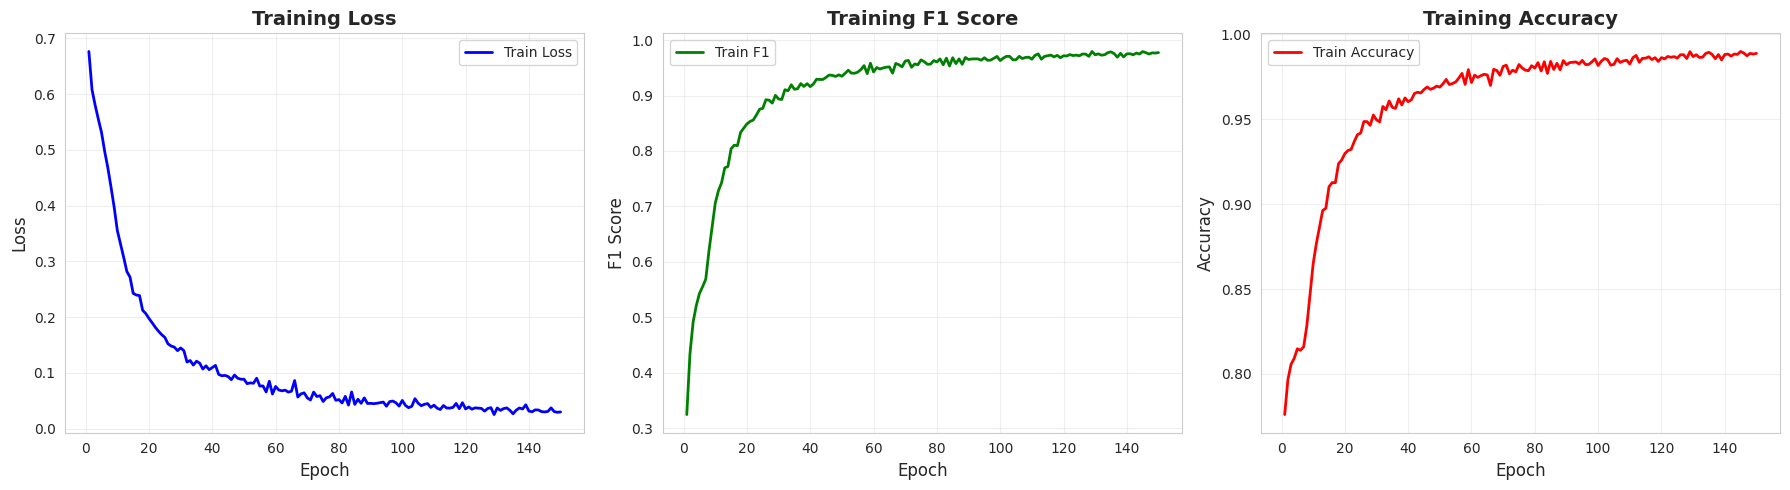

In [102]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history_final['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history_final['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# F1 Score
axes[1].plot(epochs_range, history_final['train_f1'], 'g-', linewidth=2, label='Train F1')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Training F1 Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(epochs_range, history_final['train_acc'], 'r-', linewidth=2, label='Train Accuracy')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.10 Generate Test Set Predictions

In [103]:
print("Generating predictions on test set...")
print("="*80)

# Create test dataset (use same scaler as training, only normalize joint features)
test_dataset = TimeSeriesDataset(X_test, y=None, scaler=final_train_dataset.scaler, n_joint_features=n_joint_features)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], 
                        shuffle=False, num_workers=0)

# Make predictions
final_model.eval()
test_predictions = []

with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = final_model(X_batch)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())

print(f"Generated {len(test_predictions)} raw predictions")

# If using sliding window, aggregate predictions per original sample
if use_sliding_window:
    print(f"\nAggregating predictions using majority voting...")
    print(f"  Multiple windows per sample: {len(test_predictions) / len(set(test_sample_indices)):.1f} windows/sample")
    
    # Group predictions by original sample index
    from collections import Counter
    sample_to_predictions = {}
    for sample_idx, pred in zip(test_sample_indices, test_predictions):
        if sample_idx not in sample_to_predictions:
            sample_to_predictions[sample_idx] = []
        sample_to_predictions[sample_idx].append(pred)
    
    # Aggregate using majority voting
    aggregated_predictions = []
    aggregated_sample_indices = []
    for sample_idx in sorted(sample_to_predictions.keys()):
        preds = sample_to_predictions[sample_idx]
        # Majority vote
        majority_pred = Counter(preds).most_common(1)[0][0]
        aggregated_predictions.append(majority_pred)
        aggregated_sample_indices.append(sample_idx)
    
    test_predictions_numeric = np.array(aggregated_predictions)
    final_sample_indices = aggregated_sample_indices
    print(f"  Aggregated to {len(test_predictions_numeric)} final predictions")
else:
    test_predictions_numeric = np.array(test_predictions)
    final_sample_indices = test_sample_indices

# Convert numeric predictions back to labels
test_predictions_labels = label_encoder.inverse_transform(test_predictions_numeric)

print(f"\nFinal prediction count: {len(test_predictions_labels)}")
print(f"Prediction distribution:")
unique, counts = np.unique(test_predictions_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(test_predictions_labels)*100:.1f}%)")

Generating predictions on test set...
Generated 19860 raw predictions

Aggregating predictions using majority voting...
  Multiple windows per sample: 15.0 windows/sample
  Aggregated to 1324 final predictions

Final prediction count: 1324
Prediction distribution:
  high_pain: 117 (8.8%)
  low_pain: 182 (13.7%)
  no_pain: 1025 (77.4%)


### 5.11 Create Submission CSV

In [104]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_index': final_sample_indices,
    'label': test_predictions_labels
})

# Ensure correct ordering by sample_index
submission_df = submission_df.sort_values('sample_index').reset_index(drop=True)

# Save to CSV
submission_path = '../data/submission_cnn_lstm_2.csv'
submission_df.to_csv(submission_path, index=False)

print("="*80)
print("SUBMISSION FILE CREATED!")
print("="*80)
print(f"Saved to: {submission_path}")
print(f"\nSubmission preview:")
print(submission_df.head(10))
print(f"\nTotal submissions: {len(submission_df)}")

# Verify format matches sample submission
sample_submission = pd.read_csv('../data/sample_submission.csv')
print(f"\n✓ Columns match: {list(submission_df.columns) == list(sample_submission.columns)}")
print(f"✓ Number of rows match: {len(submission_df) == len(sample_submission)}")

SUBMISSION FILE CREATED!
Saved to: ../data/submission_cnn_lstm_2.csv

Submission preview:
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
5             5  no_pain
6             6  no_pain
7             7  no_pain
8             8  no_pain
9             9  no_pain

Total submissions: 1324

✓ Columns match: True
✓ Number of rows match: True


### 5.12 Final Summary

In [105]:
print("\n" + "="*80)
print("PIPELINE COMPLETE - SUMMARY")
print("="*80)

print("\n📊 DATA:")
print(f"  • Training samples: {len(X_train_full)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Features: {n_features}")
print(f"  • Timesteps: {n_timesteps}")
print(f"  • Classes: {n_classes} {list(label_encoder.classes_)}")

print("\n🔍 GRID SEARCH:")
print(f"  • Configurations tested: {len(param_combinations)}")
print(f"  • Cross-validation folds: 5")
print(f"  • Total training runs: {len(param_combinations) * 5}")

print("\n🏆 BEST MODEL:")
# print(f"  • Mean CV F1: {best_config['mean_f1']:.4f} ± {best_config['std_f1']:.4f}")
print(f"  • Architecture:")
print(f"    - Input Embedding: {n_features} → {best_params['cnn_filters']} dims")
print(f"    - Positional Encoding: Learnable embeddings for temporal context")
print(f"    - CNN: {best_params['cnn_layers']} layers, {best_params['cnn_filters']} filters, kernel={best_params['cnn_kernel']}")
print(f"    - LSTM: {best_params['lstm_layers']} layers, {best_params['lstm_hidden']} hidden units (bidirectional)")
print(f"    - Multi-Head Attention: {best_params.get('n_heads', 4)} heads (enabled: {best_params.get('use_attention', True)})")
print(f"    - Dropout: {best_params['dropout']}")
print(f"  • Training:")
print(f"    - Learning rate: {best_params['lr']}")
print(f"    - Batch size: {best_params['batch_size']}")
print(f"    - Final train F1: {history_final['train_f1'][-1]:.4f}")
print(f"    - Total parameters: {sum(p.numel() for p in final_model.parameters()):,}")

print("\n📁 OUTPUT:")
print(f"  • Submission file: {submission_path}")
print(f"  • Predictions generated: {len(test_predictions_labels)}")

print("\n✅ Ready for submission!")
print("="*80)


PIPELINE COMPLETE - SUMMARY

📊 DATA:
  • Training samples: 9915
  • Test samples: 19860
  • Features: 36
  • Timesteps: 160
  • Classes: 3 ['high_pain', 'low_pain', 'no_pain']

🔍 GRID SEARCH:
  • Configurations tested: 1
  • Cross-validation folds: 5
  • Total training runs: 5

🏆 BEST MODEL:
  • Architecture:
    - Input Embedding: 36 → 64 dims
    - Positional Encoding: Learnable embeddings for temporal context
    - CNN: 2 layers, 64 filters, kernel=5
    - LSTM: 2 layers, 128 hidden units (bidirectional)
    - Multi-Head Attention: 4 heads (enabled: True)
    - Dropout: 0.3
  • Training:
    - Learning rate: 0.0001
    - Batch size: 64
    - Final train F1: 0.9775
    - Total parameters: 1,031,043

📁 OUTPUT:
  • Submission file: ../data/submission_cnn_lstm_2.csv
  • Predictions generated: 1324

✅ Ready for submission!
